In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

import os
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as scipystats
from scipy import signal
from scipy.ndimage import median_filter

from utils.states import get_state_as_periods
from utils.neurosuite import get_unit_names_sorted
from utils.psth import get_shuffled, get_spike_counts
from utils.spatial import gaussian_kernel_2D
from utils.spiketrain import smooth_gaussian
from utils.behavior import get_idxs_as_periods
#from utils.events import get_sound_event_periods

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Phase locking in diff states

In [4]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

In [5]:
session = "013608_ppcSIT_2025-01-14_10-20-14"

animal    = session.split('_')[0]
s_path = os.path.join(source, animal, session)
meta_file = os.path.join(source, animal, session, 'meta.h5')
phsl_file = os.path.join(source, animal, session, 'analysis', 'sound_phase_lock.h5')
unit_file = os.path.join(source, animal, session, 'units.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

with h5py.File(phsl_file, 'r') as f:
    conditions = [x for x in f]
    unit_ids   = [x for x in f[conditions[0]]]
    
spike_times = {}
with h5py.File(unit_file, 'r') as f:
    #units_to_plot = get_unit_names_sorted([name for name in f])
    for unit_name in unit_ids:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])

In [13]:
bgr_sta_mx, idxs_bgr_sta = get_state_as_periods(s_path, 'BGR', 'STA', 'AL', 4)
len(idxs_bgr_sta)

529

In [11]:
speed_max = 0.04

speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]
idxs_sta_ev = np.where(speed_ev < speed_max)[0]
idxs_run_ev = np.where(speed_ev > speed_max)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]

# times of first tgt success pulses
idxs_tgt_first_ev = tgt_mx[tgt_mx[:, 4] == 1][:, 0]
tgt_first_t = sound_events[idxs_tgt_first_ev][:, 0]

# success stays
idxs_tgt_succ = []
for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
    idxs_tgt_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_tgt_succ = np.array(idxs_tgt_succ)

In [7]:
# MRL
MRL_mx = np.zeros([len(unit_ids), 2])  # MRL, p-value
with h5py.File(phsl_file, 'r') as snd_f:
    for i, unit_name in enumerate(unit_ids):
        MRL = np.array(snd_f['tgt'][unit_name]['MRL_real'])
        pv  = np.array(snd_f['tgt'][unit_name]['p_value'])
        MRL_mx[i] = np.array([MRL, pv])

In [8]:
# mean firing rate
FR_mx = np.zeros([len(unit_ids), 2])  # MRL, mean rate, median ISI
for i, unit_id in enumerate(unit_ids):
    spiketrain = spike_times[unit_id]
   
    mean_rate = len(spiketrain) / (tl[-1][0] - tl[0][0])
    
    isis = np.diff(spiketrain)
    robust_rate = 1 / np.median(isis)
    
    FR_mx[i] = np.array([mean_rate, robust_rate])

### periods of stationarity / running

In [73]:
period_matrices = {}  
min_dur = 4  # in sounds events, 4 events per second
conds = [
    'BGR_long_stays', 
    'BGR_long_runs', 
    'SIL_long_stays',
    'SIL_long_runs',
    'TGT_long_stays',
]
idxs_conds = [
    np.intersect1d(idxs_bgr_ev, idxs_sta_ev),
    np.intersect1d(idxs_bgr_ev, idxs_run_ev),
    np.intersect1d(idxs_sil_ev, idxs_sta_ev),
    np.intersect1d(idxs_sil_ev, idxs_run_ev),
    #np.intersect1d(idxs_tgt_ev, idxs_sta_ev),
    idxs_tgt_ev
]
exclude_l, exclude_r = 2, 1  # number of events (2 beg and 1 end looks good)


for i, idxs_condition in enumerate(idxs_conds):
    periods_loc_ev = get_idxs_as_periods(idxs_condition)
    periods_filt = periods_loc_ev[np.where(np.diff(periods_loc_ev, axis=1) > min_dur)[0]]

    # don't consider first X and last Y pulses as boundary condition
    periods_filt_ex = []
    for per in periods_filt:
        per_ex = [per[0] + exclude_l, per[1] - exclude_r]
        if per_ex[1] - per_ex[0] > 1:  # at least two pulses
            periods_filt_ex.append(per_ex)
    periods_filt_ex = np.array(periods_filt_ex)

    long_pers_xy = np.zeros([len(periods_filt_ex), 4])
    for k, ls_rec in enumerate(periods_filt_ex):
        idx_tl_s = int(sound_events[ls_rec[0]][2])
        idx_tl_e = int(sound_events[ls_rec[1]][2])
        x_pos = tl[np.arange(idx_tl_s, idx_tl_e)][:, 1]
        y_pos = tl[np.arange(idx_tl_s, idx_tl_e)][:, 2]

        long_pers_xy[k] = [ls_rec[0], ls_rec[1], x_pos.mean(), y_pos.mean()]

    period_matrices[conds[i]] = long_pers_xy

# back to indices
idxs_matrices = {}
for cond, mx in period_matrices.items():
    idxs_long_pers_ev = []
    for ls in mx:
        idxs_long_pers_ev += list(np.arange(int(ls[0]), int(ls[1])))
    idxs_matrices[cond] = np.array(idxs_long_pers_ev) # sound_events[idxs_long_pers_ev][:, 0]

In [74]:
for i, (cond, mx) in enumerate(idxs_matrices.items()):
    print(f"{cond}: {mx.shape} out of {len(idxs_conds[i])}")

BGR_long_stays: (715,) out of 1756
BGR_long_runs: (29,) out of 842
SIL_long_stays: (774,) out of 2353
SIL_long_runs: (590,) out of 2172
TGT_long_stays: (971,) out of 1174


In [75]:
hw, bc = 0.25, 51
psth_matrices = {}

for i, condition in enumerate(conds):
    idxs_condition = idxs_matrices[condition]
    t_ev_sel = sound_events[idxs_condition][:, 0]
    
    psth_mx = np.zeros([len(unit_ids), bc - 1])
    for i, unit_name in enumerate(unit_ids):
        bins, psth = get_spike_counts(spike_times[unit_name], t_ev_sel, hw=hw, bin_count=bc)

        # scaling
        #scaled = (psth - np.min(psth)) / (np.max(psth) - np.min(psth))  # MinMax 
        #scaled = scipystats.zscore(psth)  # z-score

        psth_mx[i] = psth
        
    psth_matrices[condition] = psth_mx

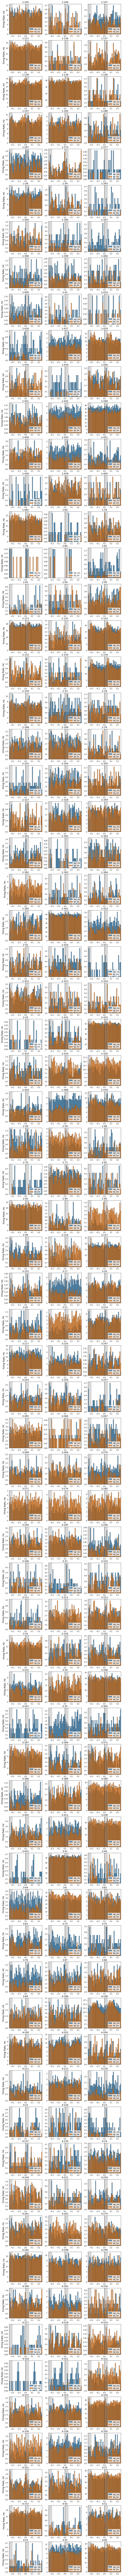

In [76]:
combs = [
    ['BGR_long_stays', 'TGT_long_stays'],
    ['BGR_long_stays', 'BGR_long_runs'],
    ['SIL_long_stays', 'SIL_long_runs']
]
label_combs = [
    ['bgr_sta', 'tgt_sta'],
    ['bgr_sta', 'bgr_run'],
    ['sil_sta', 'sil_run'],
]
color_combs = [
    ['tab:blue', 'tab:orange'],
    ['navy', 'tab:blue'],
    ['grey', 'tab:red'],
]

comb = 0
bgr_dur = 0.05
cols = 3
rows = int(np.ceil(len(unit_ids)/cols))
fig = plt.figure(figsize=(4*cols, 4*rows))

for i, unit_name in enumerate(unit_ids):
    psth1 = psth_matrices[combs[comb][0]][i]
    psth2 = psth_matrices[combs[comb][1]][i]
    
    ax = fig.add_subplot(rows, cols, i+1)
    ax.hist(bins[:-1], bins=bins, weights=psth1, edgecolor='black', color=color_combs[comb][0], alpha=0.7, label=label_combs[comb][0])
    ax.hist(bins[:-1], bins=bins, weights=psth2, edgecolor='black', color=color_combs[comb][1], alpha=0.7, label=label_combs[comb][1])
    ax.axvline(0, color='black', ls='--')
    ax.axvspan(0, bgr_dur, alpha=0.3, color='gray')
    ax.axvspan(0 - hw, 0 - hw + bgr_dur, alpha=0.3, color='gray')
    ax.set_title(unit_name, fontsize=14)
    ax.legend(loc='lower right', prop={'size': 10})
    ax.set_xlim(-hw, hw)
    if i % 3 == 0:
        ax.set_ylabel("Firing Rate, Hz", fontsize=14)